**USING RESNET18 WITH AND WITHOUT PRETRAINED WEIGHTS**

**LOADING THE SSL MODEL AND TRAINING A CLASSIFIER ON TOP OF IT**

Reference 1: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Reference 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__

        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)

    except NameError:
        return False      # Probably standard Python interpreter

In [2]:
# if is_notebook():
#     %load_ext pycodestyle_magic

In [3]:
# if is_notebook():
#     %pycodestyle_on

***

***

# Imports

## Libraries and modules

In [4]:
import utils

import os

import torch
import torchvision

from torchinfo import summary

import lightly
import copy

import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Training checks.
import time

# Showing images in the notebook.
from IPython.display import Image
from IPython.core.display import HTML

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Parser

In [5]:
# Parser (get arguments).
if __name__ == '__main__':
    import argparse
    import sys
    parser = argparse.ArgumentParser(
        description=("Script for evaluating the self-supervised learning"
                     " models and compare them to standard approaches.")
    )
    parser.add_argument(
        '--dataset',
        type=str,
        default='Sentinel2GlobalLULC',
        choices=['Sentinel2GlobalLULC', 'Sentinel2AndaluciaLULC'],
        help='Dataset name for evaluation.'
    )
    parser.add_argument(
        '--ratio',
        type=str,
        default='(0.700,0.0900,0.2100)',
        help='Dataset ratio for evaluation.'
    )
    parser.add_argument(
        '--epochs',
        type=int,
        default=15,
        help='Number of epochs for training.'
    )
    parser.add_argument(
        '--batch_size',
        type=int,
        default=64,
        help='Number of images in a batch during training.'
    )
    parser.add_argument(
        '--show_fig',
        type=bool,
        default=True,
        help='Whether the images should appear.'
    )
    parser.add_argument(
        '--cluster',
        type=bool,
        default=False,
        help=('Whether the script runs on a cluster '
              '(large memory space available).')
    )

if is_notebook():
    args = parser.parse_args(args=['--dataset', 'Sentinel2AndaluciaLULC', '--ratio', '(0.700,0.0900,0.2100)'])
else:
    args = parser.parse_args(sys.argv[1:])

## Settings

In [6]:
# Target dataset.
dataset_name = args.dataset
print(f'Target dataset name: {dataset_name}')

# Target dataset.
dataset_ratio = args.ratio
print(f'Target dataset ratio: {dataset_ratio}')

# Setting number of epochs.
epochs = args.epochs
print(f'Number of epochs: {epochs}')

# Setting batch size.
batch_size = args.batch_size
print(f'Batch size: {batch_size}')

# Show figures.
show = args.show_fig
print(f'Showing figures: {show}')

# Supercomputer?.
cluster = args.cluster
print(f'\nExecution on cluster: {cluster}')

# Avoiding the runtimeError: Too many open files.
# Communication with the workers is no longer possible.
if is_notebook() or cluster:
    print(f'Execution on jupyter or cluster: '
          f'Torch sharing strategy set to file_system (default)')
    torch.multiprocessing.set_sharing_strategy('file_descriptor')
else:
    print(f'Execution on shell with few resources: '
          'Torch sharing strategy set to file_system')
    torch.multiprocessing.set_sharing_strategy('file_system')

Target dataset name: Sentinel2AndaluciaLULC
Target dataset ratio: (0.700,0.0900,0.2100)
Number of epochs: 15
Batch size: 64
Showing figures: True

Execution on cluster: False
Execution on jupyter or cluster: Torch sharing strategy set to file_system (default)


In [11]:
# Hyperparamenters.
exp = utils.Experiment(epochs=epochs,
                       batch_size=batch_size)
print(f'\nDevice: {exp.device}\n')

# Get current directory.
cwd = os.getcwd()
print(f'Working directory: {cwd}')

# Input directory where the datasets are stored.
input_dir_datasets = os.path.join(cwd, 'datasets')
print(f'\nInput directory for datasets: {input_dir_datasets}')

# Output directory to save the model checkpoint.
output_dir_models = os.path.join(os.path.join(cwd, 'pytorch_models'),
                                'finetuning')
print(f'Output directory for model checkpoints: {output_dir_models}')

# Output folder to save the figures.
output_dir_figs = os.path.join(os.path.join(cwd, 'figures'), 'finetuning')
fig_format = '.png'  # .pdf
print(f'Output directory for figures ({fig_format} format): {output_dir_figs}')


Device: cuda

Working directory: /home/sfandres/Documents/Git/lulc

Input directory for datasets: /home/sfandres/Documents/Git/lulc/datasets
Output directory for model checkpoints: /home/sfandres/Documents/Git/lulc/pytorch_models/finetuning
Output directory for figures (.png format): /home/sfandres/Documents/Git/lulc/figures/finetuning


## Reproducibility

In [8]:
exp.reproducibility()

***

***

# Loading dataset

## Path and normalization values

In [9]:
from modules.dataset_utils import load_dataset_based_on_ratio

data_dir_target, mean, std = load_dataset_based_on_ratio(
    input_dir_datasets,
    dataset_name,
    dataset_ratio
)

Path to dataset folder: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2AndaluciaLULC
Dataset found based on the given ratio: True

Path to split folder: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2AndaluciaLULC/Sentinel2AndaluciaLULC-ratio=(0.700,0.0900,0.2100)-seed=42
Mean loaded from .txt: {'train': [0.304, 0.3048, 0.3228], 'val': [0.2995, 0.3024, 0.3211], 'test': [0.2998, 0.3018, 0.3205]}
Std loaded from .txt: {'train': [0.1347, 0.0926, 0.0724], 'val': [0.131, 0.0901, 0.0705], 'test': [0.1325, 0.0909, 0.0706]}


***

***

UP TO HERE

***

***

## Custom tranforms

In [7]:
# Data augmentations for the train dataset.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((exp.input_size, exp.input_size)),
    torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    torchvision.transforms.RandomApply([
            torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),  # not strengthened
    torchvision.transforms.RandomGrayscale(p=0.2),
    # torchvision.transforms.RandomApply([
    #     simsiam.loader.GaussianBlur([.1, 2.])
    # ], p=0.5),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean['train'], std['train'])
])

# Data augmentations for the val and test datasets.
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((exp.input_size, exp.input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean['val'], std['val'])
])

# Data augmentations for the val and test datasets.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((exp.input_size, exp.input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean['test'], std['test'])
])

## ImageFolder

In [8]:
# Loading the three datasets.
train_data = torchvision.datasets.ImageFolder(data_dir_target + '/train/',
                                              transform=train_transform)

val_data = torchvision.datasets.ImageFolder(data_dir_target + '/val/',
                                            transform=val_transform)

test_data = torchvision.datasets.ImageFolder(data_dir_target + '/test/',
                                             transform=test_transform)

In [9]:
# Get classes and number.
class_names = train_data.classes
print(class_names)

['01_BarrenLands___jpeg', '02_MossAndLichen_jpeg', '03_Grasslands____jpeg', '04_ShrublandOpen_jpeg', '05_SrublandClose_jpeg', '06_ForestsOpDeBr_jpeg', '07_ForestsClDeBr_jpeg', '08_ForestsDeDeBr_jpeg', '09_ForestsOpDeNe_jpeg', '10_ForestsClDeNe_jpeg', '11_ForestsDeDeNe_jpeg', '12_ForestsOpEvBr_jpeg', '13_ForestsClEvBr_jpeg', '14_ForestsDeEvBr_jpeg', '15_ForestsOpEvNe_jpeg', '16_ForestsClEvNe_jpeg', '17_ForestsDeEvNe_jpeg', '18_WetlandMangro_jpeg', '19_WetlandSwamps_jpeg', '20_WetlandMarshl_jpeg', '21_WaterBodyMari_jpeg', '22_WaterBodyCont_jpeg', '23_PermanentSnow_jpeg', '24_CropSeasWater_jpeg', '25_CropCereaIrri_jpeg', '26_CropCereaRain_jpeg', '27_CropBroadIrri_jpeg', '28_CropBroadRain_jpeg', '29_UrbanBlUpArea_jpeg']


## PyTorch dataloaders

In [10]:
# Dataloader for training.
dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=exp.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=exp.num_workers,
    worker_init_fn=exp.seed_worker,
    generator=exp.g
)

# Dataloader for validating.
dataloader_val = torch.utils.data.DataLoader(
    val_data,
    batch_size=exp.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=exp.num_workers,
    worker_init_fn=exp.seed_worker,
    generator=exp.g
)

# Dataloader for embedding.
dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=exp.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=exp.num_workers,
    worker_init_fn=exp.seed_worker,
    generator=exp.g
)

## Check the balance and size of the dataset

In [11]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([9800, 3259, 6208, 9800, 8355, 3105,  943, 9800, 7306, 4466, 2015,
        396,  880, 9800, 2739, 2710, 9793,  291,  340, 2943, 9800, 9800,
       9800, 1402,  589,  714,  247,  289, 8813]))


In [12]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([2800,  932, 1775, 2800, 2389,  889,  271, 2800, 2089, 1276,  577,
        115,  253, 2800,  784,  775, 2799,   84,   99,  842, 2800, 2800,
       2800,  402,  169,  204,   71,   83, 2518]))


In [13]:
# Print some stats from the train dataset.
print(len(train_data.targets))

# Print some stats from the train dataloader.
print('N samples in train dataset: ' + str(len(dataloader_train.sampler)))
print('N samples in train dataset: ' + str(len(dataloader_train.dataset)))
print('N batches in train dataset: ' + str(len(dataloader_train)))

136403
N samples in train dataset: 136403
N samples in train dataset: 136403
N batches in train dataset: 1065


In [14]:
# Print some stats from the val dataset.
print(len(val_data.targets))

# Print some stats from the val dataloader.
print('N samples in val dataset: ' + str(len(dataloader_val.dataset)))
print('N batches in val dataset: ' + str(len(dataloader_val)))

19478
N samples in val dataset: 19478
N batches in val dataset: 153


In [15]:
# Print some stats from the test dataset.
print(len(test_data.targets))

# Print some stats from the test dataloader.
print('N samples in test dataset: ' + str(len(dataloader_test.dataset)))
print('N batches in test dataset: ' + str(len(dataloader_test)))

38996
N samples in test dataset: 38996
N batches in test dataset: 305


## See some samples (pytorch dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


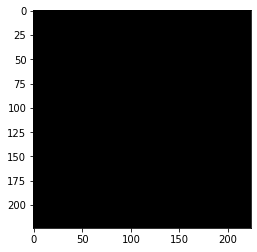

Label: 11_ForestsDeDeNe_jpeg


In [16]:
# Display image and label.
train_features, train_labels = next(iter(dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray")
plt.show()
print(f"Label: {class_names[label]}")

***

***

# Training loop

In [17]:
# Training function.
def train_model(model, criterion, optimizer, device,
                epochs=10, save_best_model=False):
    """
    Main training function.

    """

    print(f"Using {exp.device} device")

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    # Loss history.
    loss_values = {}
    loss_values['train'] = []
    loss_values['val'] = []
    total_time = 0

    # Saving best model's weights.
    best_model_val_wts = copy.deepcopy(model.state_dict())
    lowest_val_loss = 10000

    # Model to GPU if available.
    model.to(exp.device)

    # Iterating over the epochs.
    for epoch in range(epochs):

        # Initialize training loss.
        running_train_loss = 0.0

        # Start timer.
        since = time.time()

        # Enable training.
        model.train()

        for i, data in enumerate(dataloader_train):

            # Get the inputs; data is a list of [inputs, labels].
            inputs, labels = data[0].to(exp.device), data[1].to(exp.device)

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward: make predictions.
            outputs = model(inputs)

            # Compute the loss and its gradients.
            loss = criterion(outputs, labels)
            loss.backward()

            # Averaged loss across all training examples * batch_size.
            running_train_loss += loss.item() * inputs.size(0)

            if i % 200 == 199:
                print(f'T[{epoch + 1}, {i + 1:5d}] | '
                      f'Running loss: '
                      f'{running_train_loss/(i*inputs.size(0)):.4f}')

            # Adjust learning weights.
            optimizer.step()

        # Loss averaged across all training examples for the current epoch.
        epoch_train_loss = running_train_loss / len(dataloader_train.sampler)

        # Change model to evaluation mode.
        model.eval()

        # Initialize validating loss.
        running_val_loss = 0.0
        with torch.no_grad():
            for j, vdata in enumerate(dataloader_val):

                # Get the inputs; data is a list of [inputs, labels].
                vinputs, vlabels = vdata[0].to(exp.device), vdata[1].to(exp.device)

                # Forward: make predictions.
                voutputs = model(vinputs)

                # Compute the loss (w/o gradients).
                vloss = criterion(voutputs, vlabels)

                # Averaged loss across all validating examples * batch_size.
                running_val_loss += vloss.item() * vinputs.size(0)

                if j % 50 == 49:
                    print(f'V[{epoch + 1}, {j + 1:5d}] | '
                          f'Running loss: '
                          f'{running_val_loss/(j*inputs.size(0)):.4f}')

        # Loss averaged across all validating examples for the current epoch.
        epoch_val_loss = running_val_loss / len(dataloader_val.sampler)

        # Append loss values.
        loss_values['train'].append(epoch_train_loss)
        loss_values['val'].append(epoch_val_loss)

        # Deep copy the weights of the model.
        save_weights = epoch_val_loss < lowest_val_loss
        if save_weights:
            lowest_val_loss = epoch_val_loss
            best_model_train_loss = epoch_train_loss
            best_model_val_wts = copy.deepcopy(model.state_dict())

        # End timer.
        time_elapsed = time.time() - since
        total_time += time_elapsed

        # Show stats.
        print(f'Epoch: {epoch} | '
              f'Train loss: {epoch_train_loss:.4f} | '
              f'Val loss: {epoch_val_loss:.4f} | '
              f'Elapsed: {time_elapsed // 60:.0f}m '
              f'{time_elapsed % 60:.0f}s | '
              f'Save weights: {save_weights}')

    print(f'\nTraining completed in {total_time // 60:.0f}m '
          f'{total_time % 60:.0f}s')

    # Load best model weights.
    model.load_state_dict(best_model_val_wts)

    if save_best_model:

        # Move to CPU before saving it.
        model.to('cpu')

        # Filename with stats.
        save_path = f'pytorch_models/resnet18' \
                    f'-losses={best_model_train_loss:.2f}' \
                    f'_{lowest_val_loss:.2f}' \
                    f'-time={datetime.now():%Y_%m_%d-%H_%M_%S}'

        # Save this pretrained model (recommended approach).
        torch.save(model.state_dict(), save_path)

        print('Model successfuly saved')

        # Move back to the GPU.
        model.to(exp.device)

    return model, loss_values

77:80: E501 line too long (83 > 79 characters)


In [18]:
def plot_losses(loss_history, title='', save_fig=False):
    """
    Function for plotting the training and validation losses

    """

    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss_history['train'], label='Train')
    plt.plot(loss_history['val'], label='Validation')
    plt.xlabel('Epoch', labelpad=15)
    plt.ylabel('Loss', labelpad=15)
    plt.title(title)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.15)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    if save_fig:
        fig.savefig('plt_loss_values.pdf', bbox_inches='tight')

In [19]:
def evaluation_on_test(model, device):
    """
    Function to evaluate the performance
    of the model on the test dataset.

    """

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    correct = 0
    total = 0

    # Since we're not training, we don't need to calculate
    # the gradients for our outputs with torch.no_grad():
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_test):

            # Dataset.
            inputs, labels = data[0].to(device), data[1].to(device)

            # Calculate outputs by running images through the network.
            outputs = model(inputs)

            # The class with the highest energy is what we
            # choose as prediction.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Progress bar.
            if i % 50 == 49:
                print(f'Progress: {100 * i // len(dataloader_test)}%',
                      end='\r',
                      flush=True)

    print(f'Accuracy of the network on the {total} '
          f'test images: {100 * correct // total}%')

***

***

# ResNet18 from scrath

## Definition and hyperparameters

In [20]:
# Model: resnet with random weights.
model = torchvision.models.resnet18(weights=None)

## Adjust final layer

Type: linear not softmax for the moment.

In [21]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Check new final layer.
print(model.fc)

# Freezing all the network except the final layer.
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Model structure.
summary(
    model,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

Linear(in_features=512, out_features=1000, bias=True)
512
Linear(in_features=512, out_features=29, bias=True)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 29]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56] 

## Loss fcn and optimizer

In [22]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)

## Training

Using cuda device
T[1,   200] | Running loss: 2.2420
T[1,   400] | Running loss: 2.1197
T[1,   600] | Running loss: 2.0581
T[1,   800] | Running loss: 2.0219
T[1,  1000] | Running loss: 1.9994
V[1,    50] | Running loss: 1.0764
V[1,   100] | Running loss: 1.2709
V[1,   150] | Running loss: 1.1598
Epoch: 0 | Train loss: 1.9897 | Val loss: 1.1377 | Elapsed: 2m 4s | Save weights: True
T[2,   200] | Running loss: 1.8925
T[2,   400] | Running loss: 1.8753
T[2,   600] | Running loss: 1.8643
T[2,   800] | Running loss: 1.8681
T[2,  1000] | Running loss: 1.8681
V[2,    50] | Running loss: 1.2697
V[2,   100] | Running loss: 1.2487
V[2,   150] | Running loss: 1.2327
Epoch: 1 | Train loss: 1.8667 | Val loss: 1.2092 | Elapsed: 2m 3s | Save weights: False
T[3,   200] | Running loss: 1.8884
T[3,   400] | Running loss: 1.8816
T[3,   600] | Running loss: 1.8687
T[3,   800] | Running loss: 1.8582
T[3,  1000] | Running loss: 1.8602
V[3,    50] | Running loss: 0.7373
V[3,   100] | Running loss: 0.9712
V[

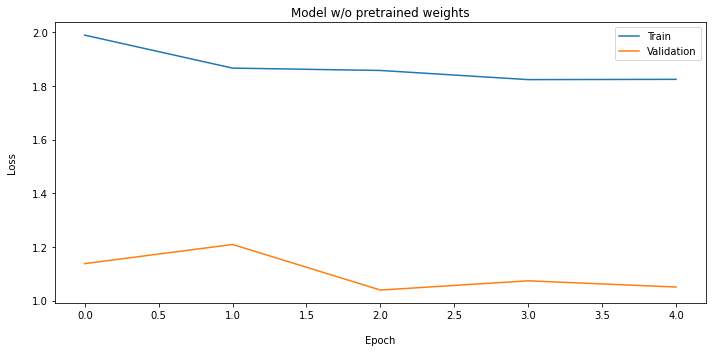

In [23]:
model, loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    exp.device,
    epochs=exp.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/o pretrained weights')

## Check performance on test dataset

In [24]:
evaluation_on_test(model, exp.device)

Accuracy of the network on the 38996 test images: 70%


## F1-score

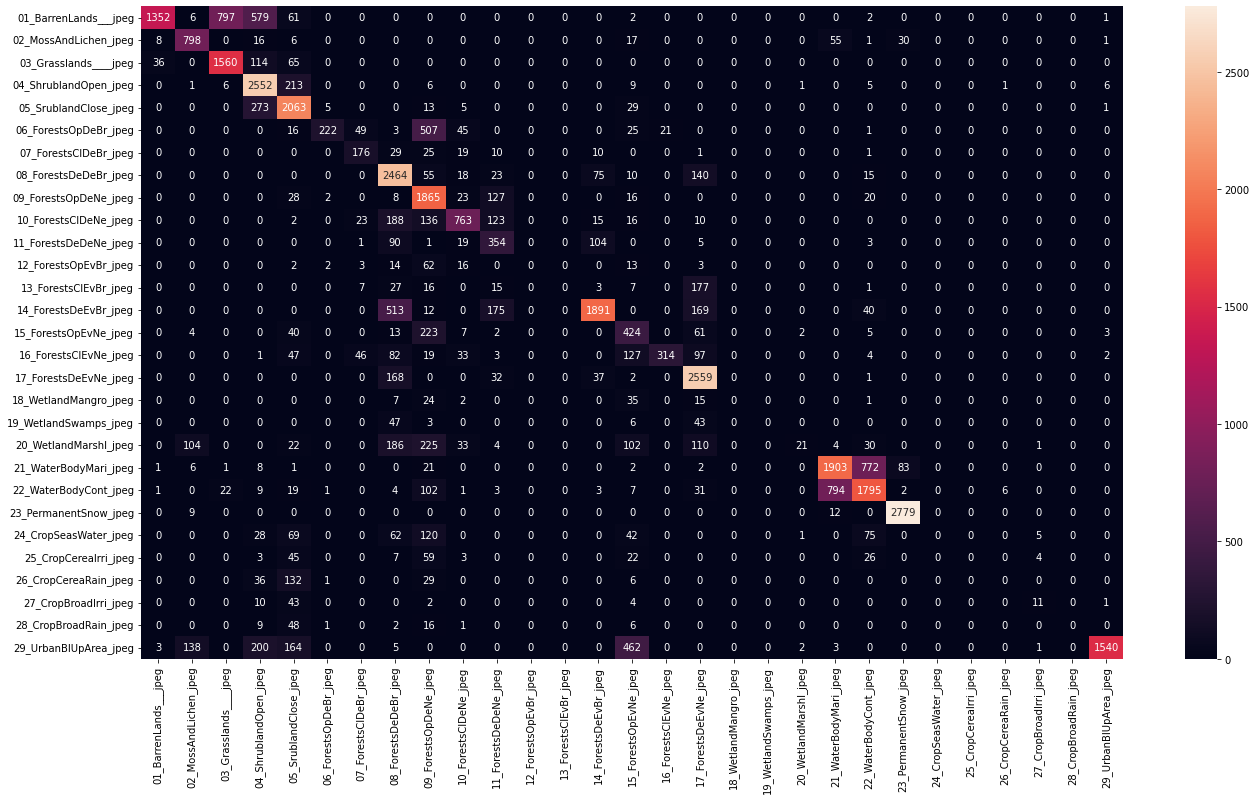

                       precision    recall  f1-score   support

01_BarrenLands___jpeg       0.48      0.97      0.64      1401
02_MossAndLichen_jpeg       0.86      0.75      0.80      1066
03_Grasslands____jpeg       0.88      0.65      0.75      2386
04_ShrublandOpen_jpeg       0.91      0.66      0.77      3838
05_SrublandClose_jpeg       0.86      0.67      0.75      3086
06_ForestsOpDeBr_jpeg       0.25      0.95      0.40       234
07_ForestsClDeBr_jpeg       0.65      0.58      0.61       305
08_ForestsDeDeBr_jpeg       0.88      0.63      0.73      3919
09_ForestsOpDeNe_jpeg       0.89      0.53      0.66      3541
10_ForestsClDeNe_jpeg       0.60      0.77      0.67       988
11_ForestsDeDeNe_jpeg       0.61      0.41      0.49       871
12_ForestsOpEvBr_jpeg       0.00      0.00      0.00         0
13_ForestsClEvBr_jpeg       0.00      0.00      0.00         0
14_ForestsDeEvBr_jpeg       0.68      0.88      0.77      2138
15_ForestsOpEvNe_jpeg       0.54      0.30      0.39  

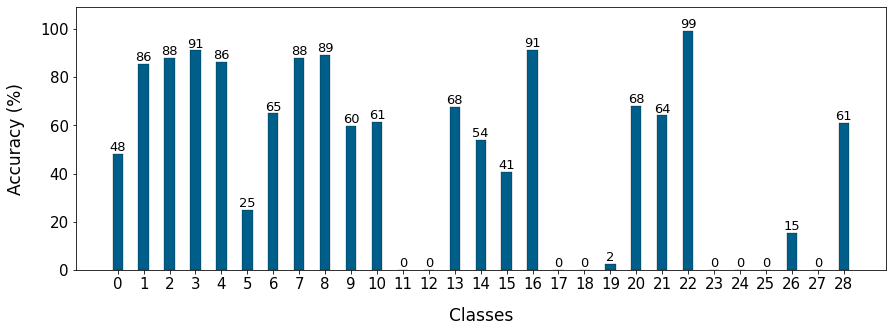

In [25]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model,
    dataloader_test,
    exp.device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***

# ResNet18 with pretrained weights

## Definition and hyperparameters

In [26]:
# Model: resnet with pretrained weights.
del model
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)

## Adjust final layer

In [27]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Parameters of newly constructed modules
# have requires_grad=True by default.
# Check new final layer.
print(model.fc)

# Freezing all the network except the final layer.
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Model structure.
summary(
    model,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

Linear(in_features=512, out_features=1000, bias=True)
512
Linear(in_features=512, out_features=29, bias=True)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 29]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56] 

## Loss fcn and optimizer

In [28]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)

## Training

Using cuda device
T[1,   200] | Running loss: 1.1858
T[1,   400] | Running loss: 1.0121
T[1,   600] | Running loss: 0.9666
T[1,   800] | Running loss: 0.9385
T[1,  1000] | Running loss: 0.9209
V[1,    50] | Running loss: 0.5034
V[1,   100] | Running loss: 0.6152
V[1,   150] | Running loss: 0.6501
Epoch: 0 | Train loss: 0.9182 | Val loss: 0.6373 | Elapsed: 2m 1s | Save weights: True
T[2,   200] | Running loss: 0.8877
T[2,   400] | Running loss: 0.8656
T[2,   600] | Running loss: 0.8710
T[2,   800] | Running loss: 0.8767
T[2,  1000] | Running loss: 0.8784
V[2,    50] | Running loss: 0.4382
V[2,   100] | Running loss: 0.5565
V[2,   150] | Running loss: 0.6436
Epoch: 1 | Train loss: 0.8765 | Val loss: 0.6302 | Elapsed: 2m 1s | Save weights: True
T[3,   200] | Running loss: 0.8996
T[3,   400] | Running loss: 0.8824
T[3,   600] | Running loss: 0.8703
T[3,   800] | Running loss: 0.8679
T[3,  1000] | Running loss: 0.8712
V[3,    50] | Running loss: 0.2994
V[3,   100] | Running loss: 0.4752
V[3

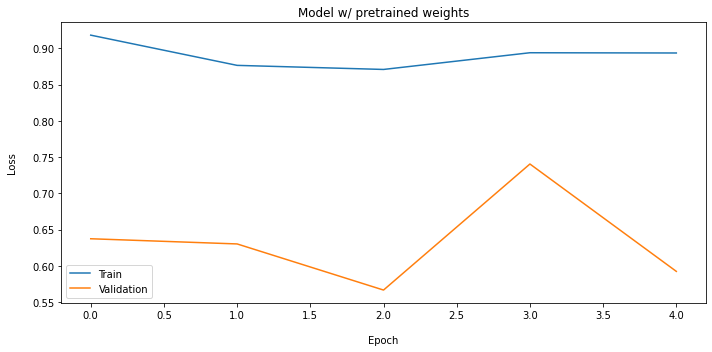

In [29]:
model, loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    exp.device,
    epochs=exp.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/ pretrained weights')

## Check performance on test dataset

In [30]:
evaluation_on_test(model, exp.device)

Accuracy of the network on the 38996 test images: 82%


## F1-score

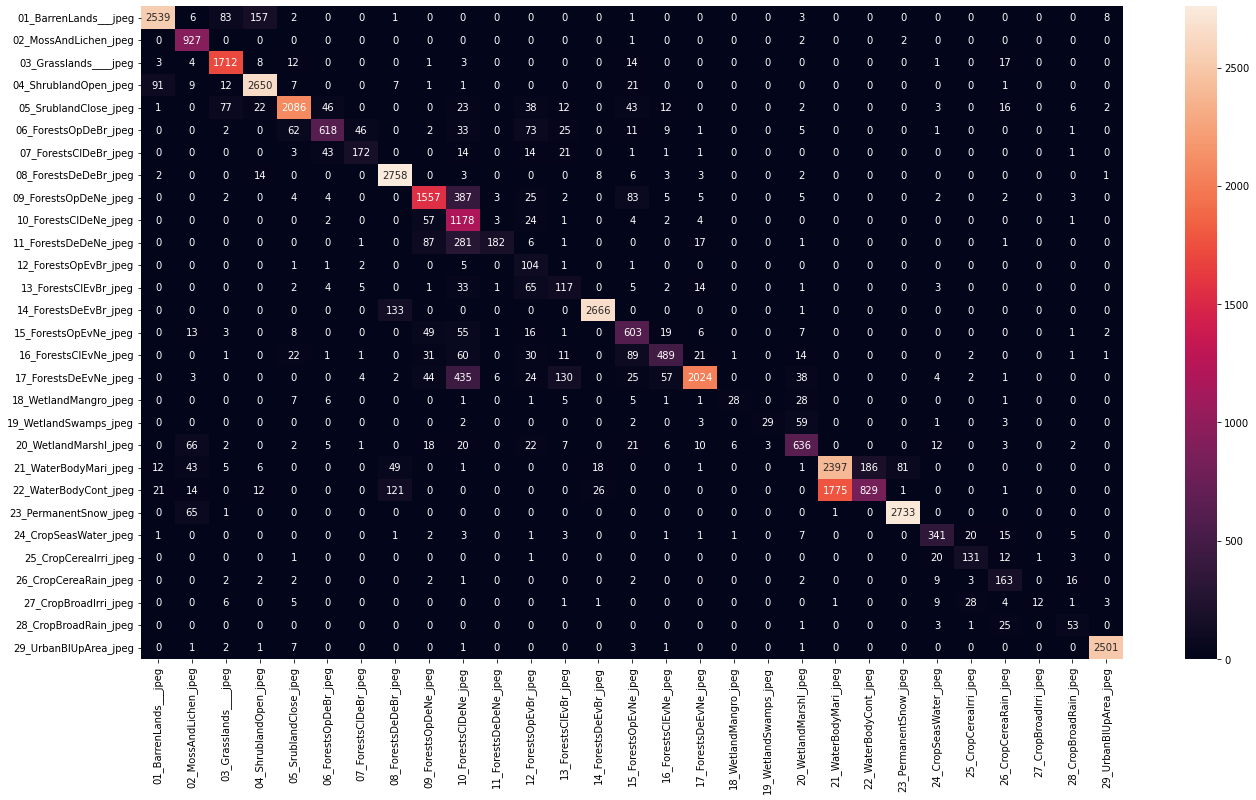

                       precision    recall  f1-score   support

01_BarrenLands___jpeg       0.91      0.95      0.93      2670
02_MossAndLichen_jpeg       0.99      0.81      0.89      1151
03_Grasslands____jpeg       0.96      0.90      0.93      1910
04_ShrublandOpen_jpeg       0.95      0.92      0.93      2872
05_SrublandClose_jpeg       0.87      0.93      0.90      2233
06_ForestsOpDeBr_jpeg       0.70      0.85      0.76       730
07_ForestsClDeBr_jpeg       0.63      0.74      0.68       232
08_ForestsDeDeBr_jpeg       0.98      0.90      0.94      3072
09_ForestsOpDeNe_jpeg       0.75      0.84      0.79      1852
10_ForestsClDeNe_jpeg       0.92      0.46      0.62      2540
11_ForestsDeDeNe_jpeg       0.32      0.93      0.47       196
12_ForestsOpEvBr_jpeg       0.90      0.23      0.37       444
13_ForestsClEvBr_jpeg       0.46      0.35      0.40       338
14_ForestsDeEvBr_jpeg       0.95      0.98      0.97      2719
15_ForestsOpEvNe_jpeg       0.77      0.64      0.70  

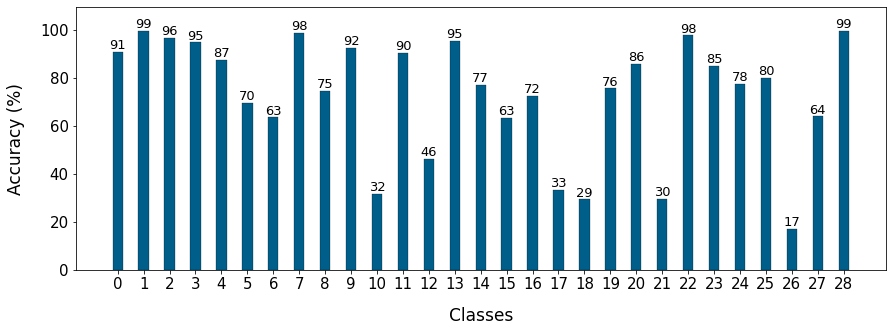

In [31]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model,
    dataloader_test,
    exp.device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***

# SSL model

## Loading

In [32]:
# State model class.
resnet18 = torchvision.models.resnet18(weights=None)

# Only backbone (w/o final fc layer).
pt_backbone = torch.nn.Sequential(*list(resnet18.children())[:-1])

In [33]:
# List of trained models.
model_list = []
for root, dirs, files in os.walk('pytorch_models/history_log/'):
    for i, filename in enumerate(sorted(files, reverse=True)):
        model_list.append(root + filename)
        print(f'{i:02}: {filename}')

00: simclr_bb_resnet18-epoch=120-train_loss=4040.9007-val_loss=578.3028-time=2022_12_08_14_13_55


In [34]:
# Loading model.
idx = 0
print(model_list[idx])
pt_backbone.load_state_dict(torch.load(model_list[idx]))

pytorch_models/history_log/simclr_bb_resnet18-epoch=120-train_loss=4040.9007-val_loss=578.3028-time=2022_12_08_14_13_55


<All keys matched successfully>

In [35]:
# Check if the model is loaded on GPU.
next(pt_backbone.parameters()).is_cuda

False

## Checking the weights

In [36]:
# First convolutional layer weights.
# print(backbone)
print(pt_backbone[0])
print(pt_backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[ 4.7476e-13,  8.5826e-13,  9.3818e-13,  1.0942e-12,  9.6889e-13,
           7.1963e-13,  4.7598e-13],
         [ 4.7285e-13,  1.1728e-12,  1.3849e-12,  1.2041e-12,  6.5750e-13,
           3.7836e-13,  1.6575e-13],
         [ 1.2287e-12,  1.7577e-12,  8.6068e-13, -5.3584e-13, -5.4277e-13,
          -7.7277e-14, -3.0756e-14],
         [ 1.2131e-12,  1.8045e-13, -1.9548e-12, -2.0122e-12,  8.1390e-14,
           8.5256e-13,  6.0314e-13],
         [ 4.1125e-14, -1.1543e-12, -1.2309e-12,  8.2682e-13,  2.1954e-12,
           1.2721e-12,  6.4639e-13],
         [ 1.1619e-13,  1.5363e-13,  9.8954e-13,  2.1548e-12,  1.7286e-12,
           2.0948e-13, -9.0703e-14],
         [ 7.3065e-14,  3.9533e-13,  8.4387e-13,  9.0048e-13,  7.7048e-14,
          -7.6954e-13, -4.7912e-13]],

        [[ 9.0513e-13,  1.2260e-12,  1.1349e-12,  1.1583e-12,  1.0343e-12,
           8.9835e-13,  8.3973e-13],
         [ 1.1447e-12,  1

## Adding a final linear layer

In [37]:
# Adding a linear layer on top of the model (linear classifier).
model_ssl = torch.nn.Sequential(
    pt_backbone,
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    # torch.nn.Softmax(dim=1)
)

# Freezing all the network except the final layer.
for param in model_ssl.parameters():
    param.requires_grad = False
# for param in model_ssl[0][7].parameters():
#     param.requires_grad = True
for param in model_ssl[2].parameters():
    param.requires_grad = True

# Model structure.
summary(
    model_ssl,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [128, 29]                 --
├─Sequential: 1-1                             [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                            [128, 64, 112, 112]       (9,408)
│    └─BatchNorm2d: 2-2                       [128, 64, 112, 112]       (128)
│    └─ReLU: 2-3                              [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [128, 64, 56, 56]         --
│    └─Sequential: 2-5                        [128, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [128, 64, 56, 56]         (73,984)
│    │    └─BasicBlock: 3-2                   [128, 64, 56, 56]         (73,984)
│    └─Sequential: 2-6                        [128, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [128, 128, 28, 28]        (230,144)
│    │    └─BasicBlock: 3-4                   [128, 128, 28, 28]    

## Loss fcn and optimizer

In [38]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model_ssl.parameters(),
                             lr=0.01)

## Training

Using cuda device
T[1,   200] | Running loss: 0.5686
T[1,   400] | Running loss: 0.4959
T[1,   600] | Running loss: 0.4662
T[1,   800] | Running loss: 0.4477
T[1,  1000] | Running loss: 0.4349
V[1,    50] | Running loss: 0.1908
V[1,   100] | Running loss: 0.2495
V[1,   150] | Running loss: 0.3133
Epoch: 0 | Train loss: 0.4313 | Val loss: 0.3072 | Elapsed: 2m 2s | Save weights: True
T[2,   200] | Running loss: 0.3892
T[2,   400] | Running loss: 0.3805
T[2,   600] | Running loss: 0.3762
T[2,   800] | Running loss: 0.3754
T[2,  1000] | Running loss: 0.3764
V[2,    50] | Running loss: 0.2035
V[2,   100] | Running loss: 0.2355
V[2,   150] | Running loss: 0.2974
Epoch: 1 | Train loss: 0.3744 | Val loss: 0.2914 | Elapsed: 2m 2s | Save weights: True
T[3,   200] | Running loss: 0.3641
T[3,   400] | Running loss: 0.3651
T[3,   600] | Running loss: 0.3635
T[3,   800] | Running loss: 0.3622
T[3,  1000] | Running loss: 0.3600
V[3,    50] | Running loss: 0.2034
V[3,   100] | Running loss: 0.2503
V[3

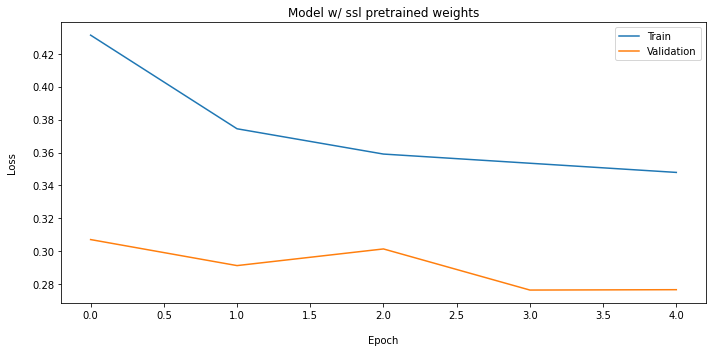

In [39]:
model_ssl, loss_history = train_model(
    model_ssl,
    loss_fn,
    optimizer,
    exp.device,
    epochs=exp.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/ ssl pretrained weights')

## Checking the weights after training

They should have remained the same (frozen) except for the final layer.

In [40]:
# First convolutional layer weights.
# print(backbone)
print(pt_backbone[0])
print(pt_backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[ 4.7476e-13,  8.5826e-13,  9.3818e-13,  1.0942e-12,  9.6889e-13,
           7.1963e-13,  4.7598e-13],
         [ 4.7285e-13,  1.1728e-12,  1.3849e-12,  1.2041e-12,  6.5750e-13,
           3.7836e-13,  1.6575e-13],
         [ 1.2287e-12,  1.7577e-12,  8.6068e-13, -5.3584e-13, -5.4277e-13,
          -7.7277e-14, -3.0756e-14],
         [ 1.2131e-12,  1.8045e-13, -1.9548e-12, -2.0122e-12,  8.1390e-14,
           8.5256e-13,  6.0314e-13],
         [ 4.1125e-14, -1.1543e-12, -1.2309e-12,  8.2682e-13,  2.1954e-12,
           1.2721e-12,  6.4639e-13],
         [ 1.1619e-13,  1.5363e-13,  9.8954e-13,  2.1548e-12,  1.7286e-12,
           2.0948e-13, -9.0703e-14],
         [ 7.3065e-14,  3.9533e-13,  8.4387e-13,  9.0048e-13,  7.7048e-14,
          -7.6954e-13, -4.7912e-13]],

        [[ 9.0513e-13,  1.2260e-12,  1.1349e-12,  1.1583e-12,  1.0343e-12,
           8.9835e-13,  8.3973e-13],
         [ 1.1447e-12,  1

## Check performance on test dataset

In [41]:
evaluation_on_test(model_ssl, exp.device)

Accuracy of the network on the 38996 test images: 89%


## F1-score

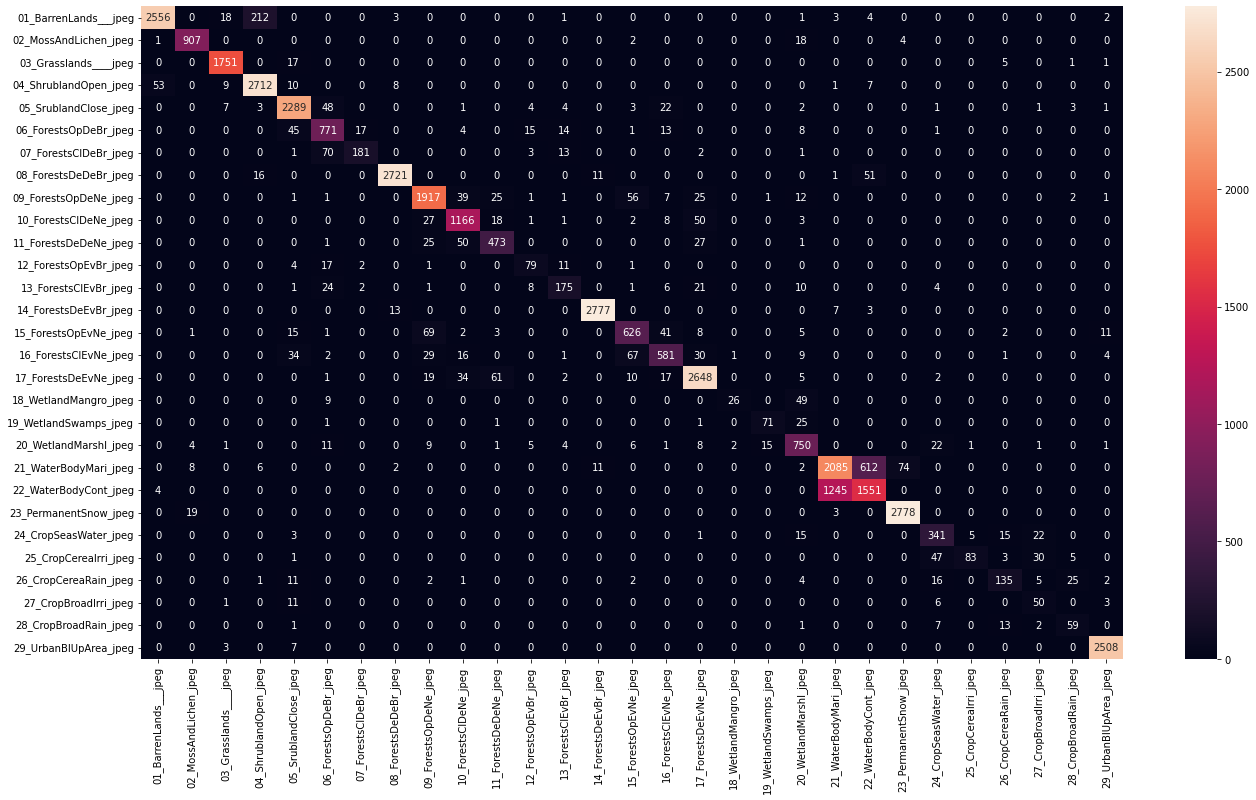

                       precision    recall  f1-score   support

01_BarrenLands___jpeg       0.91      0.98      0.94      2614
02_MossAndLichen_jpeg       0.97      0.97      0.97       939
03_Grasslands____jpeg       0.99      0.98      0.98      1790
04_ShrublandOpen_jpeg       0.97      0.92      0.94      2950
05_SrublandClose_jpeg       0.96      0.93      0.95      2451
06_ForestsOpDeBr_jpeg       0.87      0.81      0.84       957
07_ForestsClDeBr_jpeg       0.67      0.90      0.77       202
08_ForestsDeDeBr_jpeg       0.97      0.99      0.98      2747
09_ForestsOpDeNe_jpeg       0.92      0.91      0.92      2099
10_ForestsClDeNe_jpeg       0.91      0.89      0.90      1313
11_ForestsDeDeNe_jpeg       0.82      0.81      0.82       582
12_ForestsOpEvBr_jpeg       0.69      0.68      0.68       116
13_ForestsClEvBr_jpeg       0.69      0.77      0.73       227
14_ForestsDeEvBr_jpeg       0.99      0.99      0.99      2799
15_ForestsOpEvNe_jpeg       0.80      0.81      0.80  

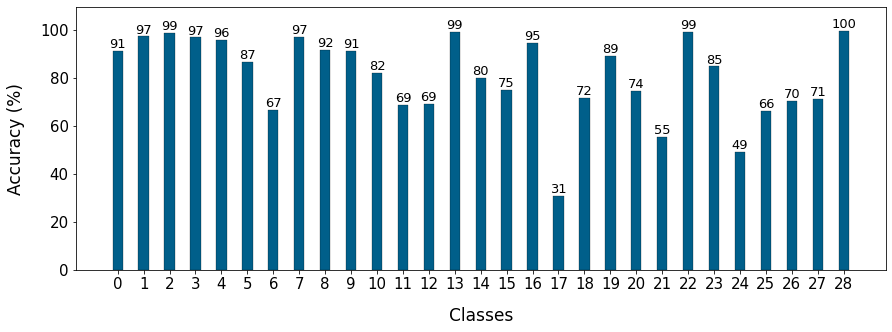

In [42]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model_ssl,
    dataloader_test,
    exp.device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***